# S-1 image processing for $\sigma^0$ retrieval from GEE + normalization
This code is a semi-automatic routine for the download of values of $\sigma^0$ from Sentinel-1 via the Google Earth Engine API. The downloaded data represent the mean value of $\sigma^0$ over the AoI, that must be provided manually into the code as a Java polygon or similar object; the variance of the data is provided as well.

- The timeseries downloaded goes from october 2014 to 31st december 2022.
- All the images are reprojected with respect to the first one of the collection, that is the same as performing coregistration of all images.
- Both VV, VH images are downloaded, from all orbits passing over the AoI.
- Normalization of $\sigma^0$ data for different orbits is provided: The chosen approach is based on the normalization of the values' distributions of different orbits on a reference distribution (Mladenova, 2013, DOI: 10.1109/TGRS.2012.2205264). The orbit that is chosen as reference by default (automatic done by the code with confirmation required from the user) is the one which average incidence angle is the closest to 40°.

**Output**

The output database has columns:
- Date: timestamp of date and time of passage rounded at hour
- Angle[°]: angle of incidence
- Geometry: name of AoI
- Orb: orbit relative number
- Pass: direction of passage, ascending or descending
- VV[dB], VH[dB]: mean values of $\sigma^0$, not normalized [NOT INCLUDED ANYMORE]
- VV_var[dB], VH_var[dB]: variance of values of $\sigma^0$ [NOT INCLUDED ANYMORE]
- VV_norm[dB], VH_norm[dB]: mean values of $\sigma^0$, normalized
- CR: cross ratio (VH/VV), performed on resampled values (linear average) in dB scale and then transformed back in linear scale (ref. Vreugdenhil, 2020, DOI: 10.3390/rs12203404 )

---

**Dependencies** 

This code requires the installation of the Earth Engine API, `ee`. You can find more info on the installation procedure here: [Python installation of GEE](https://developers.google.com/earth-engine/guides/python_install). \
This code runs on browser-based notebooks only (Google Colaboratory, Jupyter Notebooks, etc...). \
Be aware that you won't need to install the Google Cloud APK to run the code.

The full dependencies required are provided in the file of the environment google, `google.yml`. To install the virtual environment by using conda, run the lines below in the terminal after having activated `conda`.

```python
conda env create -f environment.yml # install environment from file environment.yml
conda activate <myenv> # activate environment with name provided by header of .yml file
conda info --envs # to check if everything worked fine
```
If you don't use `conda`, manually install the dependencies listed in the environment file by using `pip`.

---

In [1]:
from funcs_gee import *

In [3]:
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

AttributeError: module 'ee' has no attribute 'Authenticate'

In [3]:
# Filters definition
# fil_orb95   = ee.Filter.eq('relativeOrbitNumber_start', 95)
# fil_orb168  = ee.Filter.eq('relativeOrbitNumber_start', 168)
# fil_orb117 = ee.Filter.eq('relativeOrbitNumber_start', 117)

sp17 = ee.Filter.date('2017-04-04', '2017-05-22') # related to Budrio field
su17 = ee.Filter.date('2017-05-22', '2017-09-15') # related to Budrio field
au17 = ee.Filter.date('2017-09-15', '2017-11-02') # related to Budrio field

# missing data on 2016-10-01 raises not-exceptable exception
# tot = ee.Filter.date('2014-10-03', '2022-12-01')
tot1 = ee.Filter.date('2014-10-03', '2016-09-30')
tot2 = ee.Filter.date('2016-10-02', '2022-12-01')

In [4]:
print('Define area of interest. \nIf you have a GeoJSON file, copy paste.\n'+
      'If you have a KML, export to GeoJSON (plenty of free tools online).')

geoJSON = {
"type": "FeatureCollection",
"name": "merged",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "Name": "Budrio_campo_safe_half", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.53262979564736, 44.570842547510622 ], [ 11.532328100248961, 44.570445732016537 ], [ 11.53264162483709, 44.570339694294631 ], [ 11.532950828277439, 44.570738040751841 ], [ 11.53262979564736, 44.570842547510622 ] ] ] } } ] }

nfeatures = len(geoJSON['features'])
coords = [geoJSON['features'][i]['geometry']['coordinates'] for i in range(nfeatures)]
aoi = ee.Geometry.MultiPolygon(coords)

geometry_title = input('Please provide a title for AoI geometry. (Default: Budrio_half-right)')
if not geometry_title: geometry_title='Budrio_half-right'

Define area of interest. 
If you have a GeoJSON file, copy paste.
If you have a KML, export to GeoJSON (plenty of free tools online).


Please provide a title for AoI geometry. (Default: Budrio_half-right) budrio-half


In [5]:
# Get collection of images and filter
img1 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot1)
        .sort('system:time_start'))
img2 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot2)
        .sort('system:time_start'))

# acq_times = img.aggregate_array('system:time_start').getInfo()
# len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

In [6]:
# Reprojection of images
# This action is equivalent to performing coregistration of the images
# to ensure that the coordinates are coherent in the whole collection

proj=img1.first().select('VV').projection();
scale_mod=ee.Number(proj.nominalScale()).getInfo()
trans_mod=proj.getInfo()['transform'];
crs_mod=proj.getInfo()['crs'];

img1 = img1.map(lambda image: image.reproject(crs_mod,trans_mod))
img2 = img2.map(lambda image: image.reproject(crs_mod,trans_mod))

In [7]:
def extract_data(image:ee.Image):
    """Ausiliary function to extract data from an Image
    
    This function extracts spatial means and std.dev
    via spatial reducers (reduceRegion).
    Optimal implementation is to map this function
    on a whole ImageCollection via .map() and insert the
    return into a ee.FeatureCollection.
    
    Return
    ------
    ee.Feature
    
    """
    try:
        mean = image.reduceRegion(**{ 
            'reducer': ee.Reducer.mean(),
            'geometry': aoi,
        })
        
        dev = image.reduceRegion(**{ 
            'reducer': ee.Reducer.stdDev(),
            'geometry': aoi,
        })
        
        var = image.reduceRegion(**{
            'reducer':ee.Reducer.variance(),
            'geometry': aoi,
        })
    
        properties = {
            'Date': image.get('system:time_start'), # only way to get a timestr is an external operation
            'Geometry': geometry_title,
            'VV[lin]': mean.get('VV'),
            'VH[lin]': mean.get('VH'),
            'Angle[°]': mean.get('angle'),
            'VV_var[lin]': var.get('VV'),
            'VH_var[lin]': var.get('VH'),
            'Orb': image.get('relativeOrbitNumber_start'),
            'Pass': image.get('orbitProperties_pass'),
        }
    except: HttpError, EEException            
            
    return ee.Feature(None, properties)

In [8]:
def clean_date(date:int):
    return time.strftime('%x %H', time.localtime((date)/1000))

dflist = []
for img in [img1, img2]:
    data = ee.FeatureCollection(img.map(extract_data))
    data_out = data.getInfo()
    data_out_to_df = [e.get('properties') for e in data_out.get('features')]; data_out_to_df[0]
    df = pd.DataFrame.from_dict(data_out_to_df)
    df.Date = df.Date.apply(lambda x : pd.to_datetime(clean_date(x)))
    df['VV[dB]'] = df['VV[lin]'].apply(lambda x : lin_db(x))
    df['VH[dB]'] = df['VH[lin]'].apply(lambda x : lin_db(x))
    df['VV_var[dB]'] = df['VV_var[lin]']/df['VV[lin]']*(10/np.log(10))
    df['VH_var[dB]'] = df['VH_var[lin]']/df['VH[lin]']*(10/np.log(10))
    dflist.append(df)

dftot = pd.concat([dflist[0],dflist[1]]).set_index('Date'); dftot

,Angle[°],Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB]
Date,,,,,,,,,,,,
2014-10-12 07:00:00,41.268929,budrio-half,95,DESCENDING,0.021763,0.000042,0.182534,0.003403,-7.386558,-16.622857,0.080961,0.008327
2014-10-12 07:00:00,41.268929,budrio-half,95,DESCENDING,0.021763,0.000042,0.182534,0.003403,-7.386558,-16.622857,0.080961,0.008327
2014-10-24 07:00:00,41.271503,budrio-half,95,DESCENDING,0.006081,0.000007,0.070802,0.000520,-11.499540,-22.160267,0.031897,0.005314
2014-11-17 06:00:00,41.107655,budrio-half,95,DESCENDING,0.021245,0.000081,0.197806,0.005158,-7.037598,-16.727359,0.113249,0.016511
2014-11-29 06:00:00,41.106918,budrio-half,95,DESCENDING,0.021670,0.000024,0.173129,0.004573,-7.616294,-16.641461,0.114723,0.004907
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,budrio-half,117,ASCENDING,0.013427,0.000007,0.083400,0.001255,-10.788347,-18.720118,0.065349,0.002347
2022-11-16 06:00:00,31.267229,budrio-half,168,DESCENDING,0.017162,0.000014,0.186391,0.003381,-7.295749,-17.654220,0.078771,0.003636
2022-11-23 06:00:00,41.307030,budrio-half,95,DESCENDING,0.029266,0.000051,0.276107,0.004051,-5.589231,-15.336425,0.063719,0.007622


# Backscattering normalization

Ref: DOI: 10.1109/tgrs.2012.2205264, https://ieeexplore.ieee.org/document/6264094 (Mladenova (2013))

In [9]:
import warnings

# need orbits in databaes: exploit sets' uniquity
orb_list = [*set(dftot.Orb.values)]

n=0
leng_list=[]
for orb in orb_list:
    leng = len(dftot[dftot.Orb==orb]) 
    print(f'orbit {orb} has {leng} data')
    if leng==1:
        warnings.warn(f'\nOrbit {orb} has only 1 datum. '+
                      'This orbit will be ignored.')
    leng_list.append(leng)
    n+=leng
print(f'total number of data is {n}')

bad_orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]==1]
orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]>1]; orb_list

for bad in bad_orb_list:
    dftot=dftot.drop(dftot[dftot.Orb==bad].index)

orbit 168 has 384 data
orbit 117 has 382 data
orbit 95 has 385 data
total number of data is 1151


In [10]:
normdict = dict()
nnormdict = dict()

for orb in orb_list:
    d = dict()
    for pol in ['VV','VH']:
        d[f'{pol}']      = dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values
        d[f'{pol}_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        d[f'{pol}_std']  = np.std(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        if d[f'{pol}_std']==0: d[f'{pol}_std']=np.sqrt(abs(d[f'{pol}_mean']))
        d[f'angle_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'Angle[°]'].values)
    d['angle'] = dftot.loc[dftot.Orb==orb][f'Angle[°]'].values
    normdict[orb] = d
    
normdf = pd.DataFrame.from_dict(normdict, orient='index'); normdf
statsnorm = normdf.drop(columns=['VV','VH','angle']); statsnorm

,VV_mean,VV_std,angle_mean,VH_mean,VH_std
168,-8.283063,3.097937,31.331243,-18.439091,3.713971
117,-10.533969,2.898430,37.400273,-18.849867,3.362747
95,-9.994485,2.680490,41.278774,-19.187305,3.427971


In [16]:
normdf

,VV,VV_mean,VV_std,angle_mean,VH,VH_mean,VH_std,angle
168,"[-9.651884185325562, -13.146026525983995, -15....",-8.283063,3.097937,31.331243,"[-15.663469587529722, -18.000240393342267, -19...",-18.439091,3.713971,"[31.273954391479492, 31.273521423339844, 31.27..."
117,"[-11.42048474389352, -14.978266387801328, -15....",-10.533969,2.898430,37.400273,"[-17.908337632201505, -18.889934993414855, -19...",-18.849867,3.362747,"[37.32086944580078, 37.30653381347656, 37.3090..."
95,"[-7.386558393477579, -7.386558393477579, -11.4...",-9.994485,2.680490,41.278774,"[-16.62285657791275, -16.62285657791275, -22.1...",-19.187305,3.427971,"[41.26892852783203, 41.26892852783203, 41.2715..."


In [11]:
# Find orbit that has mean angle nearest to 40°
# and choose it as reference statistics
orb_ref = normdf.angle_mean.apply(lambda x : abs(x-40)).sort_values().head(1).index.values[0]
if not input(f'The orbit with mean incidence angle nearest to 40° is orbit {orb_ref}. '+
             'This orbit will be taken as reference orbit for normalization. Proceed? [[]/any]')=='':
    raise NameError('Manually set orb_ref variable with chosen reference orbit (type:int).')
else: print(f'\nOrbit {orb_ref} has been set as reference orbit.')

# for orb in orb_list:
#     d = dict()
#     for pol in ['VV', 'VH']:
#         d[f'{pol}']      = HIST_norm(
#             normdf.loc[orb_ref][f'{pol}_mean'],
#             normdf.loc[orb_ref][f'{pol}_std'],
#             [
#                 normdf.loc[orb][pol],
#                 normdf.loc[orb][f'{pol}_mean'],
#                 normdf.loc[orb][f'{pol}_std'],
#             ]
#                  )
#         d[f'{pol}_mean'] = np.mean(d[f'{pol}'])
#         d[f'{pol}_std']  = np.std(d[f'{pol}'])
#     nnormdict[orb] = d
#     
# nnormdf = pd.DataFrame.from_dict(nnormdict, orient='index')

dftot['VV_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VV_mean'][orb_ref],
        statsnorm['VV_std'][orb_ref],
        [   
            x['VV[dB]'],    
            statsnorm['VV_mean'][x.Orb],    
            statsnorm['VV_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

dftot['VH_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VH_mean'][orb_ref],
        statsnorm['VH_std'][orb_ref],
        [   
            x['VH[dB]'],    
            statsnorm['VH_mean'][x.Orb],    
            statsnorm['VH_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

print('\nThis cell includes a duplicates drop from the dataframe, so you may see a change in the number of values of the dataframe after performing it.')
print('\nThis is also the cell in which the columns containing not-normalized data are dropped. If you need to mantain those, comment the line below (in the code).')
dftot=dftot.drop(['VH[lin]','VH_var[lin]','VV[lin]','VV_var[lin]',
                 'VV[dB]','VH[dB]','VV_var[dB]','VH_var[dB]'], axis=1)
dftot['CR'] = db_lin(dftot['VH_norm[dB]'].values-dftot['VV_norm[dB]'].values)
dftot.drop_duplicates(inplace=True)
dftot.dropna(inplace=True)
dftot

The orbit with mean incidence angle nearest to 40° is orbit 95. This orbit will be taken as reference orbit for normalization. Proceed? [[]/any] 



Orbit 95 has been set as reference orbit.

This cell includes a duplicates drop from the dataframe, so you may see a change in the number of values of the dataframe after performing it.

This is also the cell in which the columns containing not-normalized data are dropped. If you need to mantain those, comment the line below (in the code).


,Angle[°],Geometry,Orb,Pass,VV_norm[dB],VH_norm[dB],CR
Date,,,,,,,
2014-10-12 07:00:00,41.268929,budrio-half,95,DESCENDING,-7.386558,-16.622857,0.119226
2014-10-24 07:00:00,41.271503,budrio-half,95,DESCENDING,-11.499540,-22.160267,0.085887
2014-11-17 06:00:00,41.107655,budrio-half,95,DESCENDING,-7.037598,-16.727359,0.107405
2014-11-29 06:00:00,41.106918,budrio-half,95,DESCENDING,-7.616294,-16.641461,0.125165
2014-12-23 06:00:00,41.107285,budrio-half,95,DESCENDING,-8.727765,-17.384113,0.136259
...,...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,budrio-half,117,ASCENDING,-10.229735,-19.055039,0.131060
2022-11-16 06:00:00,31.267229,budrio-half,168,DESCENDING,-9.140211,-18.462874,0.116878
2022-11-23 06:00:00,41.307030,budrio-half,95,DESCENDING,-5.589231,-15.336425,0.105994


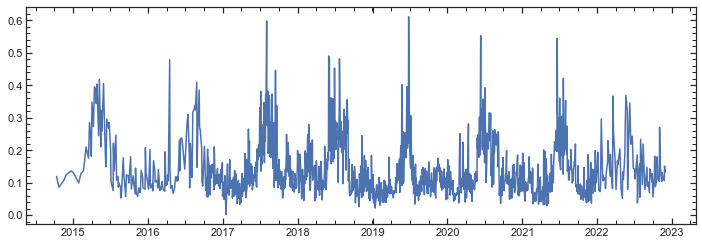

In [19]:
plt.figure(figsize=(12,4))
plt.plot(dftot.CR)

In [13]:
opt_save_df = input('Save df? [y/n]')
if opt_save_df=='y':
    filename = input('Provide filename without extension (def. .csv): [default:geometry name] ')
    if filename=='': filename = geometry_title 
    dftot.to_csv(f'{filename}.csv', sep = '\t')

Save df? [y/n] n


# Plots

In [14]:
def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=True, opt_save=False, opt_name='hist_fit',
                  ):
    
    def gauss(x, A, mean, dev):
        """Not-normalized, shifted gaussian distribution."""
        import math
        return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

    counts, bins, pads = plt.hist(data, bins=nbins, density=True, **hist_kwargs)
    fit_bounds = [ [0,min(bins),0], [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    popt, pcov = curve_fit(gauss, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    A, mean, dev = popt[0], popt[1], popt[2]
    x = np.linspace(min(data), max(data), 50)
    fit = gauss(x, A, mean, dev)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts';    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    if opt_save: plt.savefig(opt_name+'.png', dpi=300)
    return counts, bins, pads

Save plots? [y/n] n


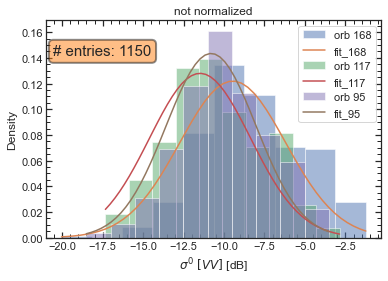

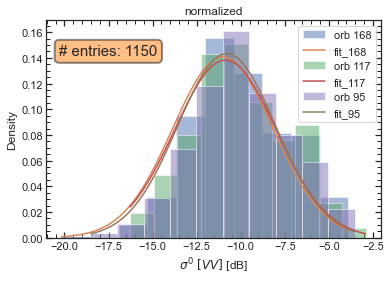

In [15]:
# Histograms plots

opt_save=True if input('Save plots? [y/n]')=='y' else False
opt_name_plot = 'hist_'+geometry_title

normdf.dropna(inplace=True)
nnormdf.dropna(inplace=True)

# Not normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = normdf['VV'][orb]
    counts, bins, pads = hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs,
                                        fitline_kwargs=fitline_kwargs,
                                        title='not normalized', density=True, opt_save=opt_save, 
                                        opt_name=opt_name_plot+'_not-norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')
t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

# Normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = nnormdf['VV'][orb]
    counts, bins, pads = hist_gauss_fit(data, nbins=10,
                                        hist_kwargs=hist_kwargs,
                                        fitline_kwargs=fitline_kwargs,
                                        title='normalized', density=True,
                                        opt_save=opt_save, opt_name=opt_name_plot+'_norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')

t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))